<a href="https://colab.research.google.com/github/nurfnick/NetworkScience/blob/main/HomeworkAssignments/Homework1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Network Science Homework #1

## Nicholas Jacob

Learning and Playing with networkx package in python

## Loading Packages

We start with the general loading of packages.  I find this very boring so I use the code as suggested in the assignment

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# Optional community detection package (e.g., python-louvain)
# from community import community_louvain

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Plot defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['axes.grid'] = True
%matplotlib inline
#added this for nicer display of graphics

##Dataset

I love to ride my bike to campus.  So when I saw the NYC Citibikes on the list it was a no brainer which set I would choose.  I have actually worked with this data before using BigQuery an SQL teaching tool.  It will be fun to revisit.  I chose the most recent available data for July of 2025.  Data was gathered from [Citi Bike NYC](https://citibikenyc.com/system-data) on 8.30.2025.  Data was extracted from zip and uploaded to my github account.  We will load the raw data here in a pandas dataframe.

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/nurfnick/NetworkScience/refs/heads/main/HomeworkAssignments/JC-202507-citibike-tripdata.csv')
print(df.shape)
display(df.head())
print(df.dtypes)

(107726, 13)


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,8974E7FE6E43119D,electric_bike,2025-07-13 21:07:32.221,2025-07-14 03:12:34.695,Bergen Ave & Sip Ave,JC109,NaN,NaN,40.731009,-74.064437,NaN,NaN,casual
1,31EF8E5CBC2FA664,electric_bike,2025-07-10 19:02:28.736,2025-07-10 19:19:43.664,Stevens - River Ter & 6 St,HB602,NaN,NaN,40.743133,-74.026989,NaN,NaN,casual
2,F0FB644DB2CDEE04,electric_bike,2025-07-04 14:02:35.827,2025-07-04 15:48:04.024,Grove St PATH,JC115,NaN,NaN,40.719410,-74.043090,NaN,NaN,casual
3,DB7BEA3FEC700AC5,electric_bike,2025-07-18 14:46:32.568,2025-07-18 14:59:42.892,14 St Ferry - 14 St & Shipyard Ln,HB202,NaN,NaN,40.752961,-74.024353,NaN,NaN,member
4,772B1CAA099E7DA5,classic_bike,2025-07-13 10:49:03.936,2025-07-14 11:48:59.171,Southwest Park - Jackson St & Observer Hwy,HB401,NaN,NaN,40.737551,-74.041664,NaN,NaN,casual


ride_id                object
rideable_type          object
started_at             object
ended_at               object
start_station_name     object
start_station_id       object
end_station_name       object
end_station_id         object
start_lat             float64
start_lng             float64
end_lat               float64
end_lng               float64
member_casual          object
dtype: object


So there are 100k rides over the timeframe we are interested in.  We want to study networks here so we will be interested in a directed graph, looking at start_station and end_station.  I will utilize the id as I don't really care what the name was.  I may also be able to use the latatude and longitude to create a directed graph in the geographic shape, but that is a push project after we first get the required things finished.




## Data Cleaning

We see right away that the data maybe a bit dirty.  We see that the first five rides do not have an end_station_name.  This is exactly the variable we are interested in!  Let's do a bit of cleaning and get rid of any rides that do not have a start and an end station so our directed graph will work.

In [3]:
df = df.dropna(subset=['start_station_id', 'end_station_id'])
print(df.shape)
display(df.head())

(107388, 13)


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
6,8F19BE0DE5818EE7,electric_bike,2025-07-26 00:10:22.629,2025-07-26 00:28:00.524,Dey St,JC065,Heights Elevator,JC059,40.737711,-74.066921,40.748716,-74.040443,casual
7,4D41624CF8121C30,electric_bike,2025-07-21 11:34:47.453,2025-07-21 11:45:21.076,Newark Ave,JC032,Heights Elevator,JC059,40.721525,-74.046305,40.748716,-74.040443,casual
8,252C61A68D1A4D4D,electric_bike,2025-07-17 18:48:20.635,2025-07-17 19:04:21.382,River St & Newark St,HB106,Heights Elevator,JC059,40.736722,-74.029007,40.748716,-74.040443,member
9,D17EAF8CB497AC0D,electric_bike,2025-07-26 17:55:39.234,2025-07-26 18:00:58.256,River St & Newark St,HB106,6 St & Grand St,HB302,40.736722,-74.029007,40.744398,-74.034501,casual
10,CF2D4906BAF9DBF7,classic_bike,2025-07-14 15:01:40.049,2025-07-14 15:13:38.036,Harborside,JC104,6 St & Grand St,HB302,40.719252,-74.034234,40.744398,-74.034501,casual


I want to check that I am within the month on all the rides so I will restrict the data further but first I must get into datetime format.

In [4]:
df.started_at = pd.to_datetime(df.started_at)
df.ended_at = pd.to_datetime(df.ended_at)
print(df.dtypes)

ride_id                       object
rideable_type                 object
started_at            datetime64[ns]
ended_at              datetime64[ns]
start_station_name            object
start_station_id              object
end_station_name              object
end_station_id                object
start_lat                    float64
start_lng                    float64
end_lat                      float64
end_lng                      float64
member_casual                 object
dtype: object


Now I will get rid of data outside the time frame of July 2025.

In [5]:
df = df[(df.started_at > '2025-07-01') & (df.started_at < '2025-08-01')]
print(df.shape)
display(df.head())

(107375, 13)


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
6,8F19BE0DE5818EE7,electric_bike,2025-07-26 00:10:22.629,2025-07-26 00:28:00.524,Dey St,JC065,Heights Elevator,JC059,40.737711,-74.066921,40.748716,-74.040443,casual
7,4D41624CF8121C30,electric_bike,2025-07-21 11:34:47.453,2025-07-21 11:45:21.076,Newark Ave,JC032,Heights Elevator,JC059,40.721525,-74.046305,40.748716,-74.040443,casual
8,252C61A68D1A4D4D,electric_bike,2025-07-17 18:48:20.635,2025-07-17 19:04:21.382,River St & Newark St,HB106,Heights Elevator,JC059,40.736722,-74.029007,40.748716,-74.040443,member
9,D17EAF8CB497AC0D,electric_bike,2025-07-26 17:55:39.234,2025-07-26 18:00:58.256,River St & Newark St,HB106,6 St & Grand St,HB302,40.736722,-74.029007,40.744398,-74.034501,casual
10,CF2D4906BAF9DBF7,classic_bike,2025-07-14 15:01:40.049,2025-07-14 15:13:38.036,Harborside,JC104,6 St & Grand St,HB302,40.719252,-74.034234,40.744398,-74.034501,casual


This did delete a few rides.  I did not need to write the code above, colab made it as a suggestion after I had written what I intended to do.  Coding is so strange now...

## BiPartite Graph

In [6]:
top_col = 'start_station_id'
bottom_col = 'end_station_id'
B = nx.Graph()
B.add_nodes_from(df[top_col].unique(), bipartite=0)
B.add_nodes_from(df[bottom_col].unique(), bipartite=1)
edges = list(zip(df[top_col], df[bottom_col]))
B.add_edges_from(edges)
print('Bipartite nodes:', B.number_of_nodes(), 'edges:', B.number_of_edges())

Bipartite nodes: 213 edges: 3382


So while this was the suggested code, I see a problem right away!  I cannot create a bipartite graph using the same nodes for the start station and the end station.  To get around this, I used the name of the station for the start and the id for the end.

In [7]:
top_col = 'start_station_name'
bottom_col = 'end_station_id'
B = nx.Graph()
B.add_nodes_from(df[top_col].unique(), bipartite=0)
B.add_nodes_from(df[bottom_col].unique(), bipartite=1)
edges = list(zip(df[top_col], df[bottom_col]))
B.add_edges_from(edges)
print('Bipartite nodes:', B.number_of_nodes(), 'edges:', B.number_of_edges())

Bipartite nodes: 297 edges: 5903


This did change the graph a bit for sure!  I bet we are seeing more edges because direction now matters.  We don't see twice as many but perhaps some stations are just under used across the network.  We think this is the correct approach for a bipartite graph using this specific data.

## One Mode Projection

In [9]:
from networkx.algorithms import bipartite
bottom_nodes = [n for n,d in B.nodes(data=True) if d.get('bipartite')==1]
G = bipartite.weighted_projected_graph(B, bottom_nodes)
largest_cc = max(nx.connected_components(G), key=len)
G = G.subgraph(largest_cc).copy()
print('Projected G:', G.number_of_nodes(), 'nodes /', G.number_of_edges(), 'edges')

Projected G: 213 nodes / 14250 edges


So I am very suprised about this result.  We see more edges!  Of course in the original bi-partite graph about the same number edges were possible but we see that the destinations were a significant portion of the nodes, 213 vs 84 starting stations.  This may be a quirk of the data or a fact about the network and where you can check out bikes vs where they can be returned to.

## Degree and Weighted Degree

In [12]:
degree = dict(G.degree())
weighted_degree = dict(G.degree(weight='weight'))

degree_df = pd.DataFrame.from_dict(degree, orient='index', columns=['degree'])
weighted_degree_df = pd.DataFrame.from_dict(weighted_degree, orient='index', columns=['weighted_degree'])

degree_df = degree_df.sort_values(by='degree', ascending=False)
weighted_degree_df = weighted_degree_df.sort_values(by='weighted_degree', ascending=False)

display(degree_df.head(10))
display(weighted_degree_df.head(10))

,degree
HB612,212
JC014,212
JC082,212
JC032,212
JC115,212
JC008,212
JC116,212
JC098,211
JC104,211
JC013,211


,weighted_degree
JC098,68.404762
JC066,68.035714
JC013,68.011905
JC008,67.976190
JC032,67.797619
JC009,67.773810
JC014,67.702381
JC082,67.166667
JC006,66.714286
HB101,66.464286


Honestly, I started typing 'degree' and gemini auto completed the rest.  Only change I had to make was to ask head to give 10 items instead of 5.  I feel so worthless coding now...

array([[<Axes: title={'center': 'degree'}>]], dtype=object)

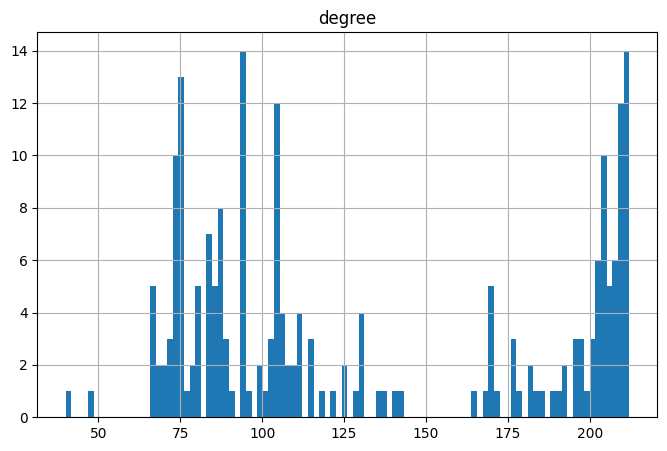

In [13]:
degree_df.hist(bins = 100)

I knew how to create a quick histogram with pandas data!

## Connected Components

In [16]:
nx.number_connected_components(G)
nx.diameter(G)
nx.average_shortest_path_length(G)

1.3688546372575072

## Gemini LLM Logs

I am fairly new to using the LLMs but I figured I would try.  
1.  I needed to remove the 'NaN' from start and end stations so I asked gemini to do that with the following prompt:


> Can you remove all nan from the df

Here is the code it provided:

> df_cleaned = df.dropna(subset=['start_station_id', 'end_station_id']).copy()

>print(df_cleaned.shape)

>display(df_cleaned.head())

Clearly it had read what I typed outside of the prompt and did more than I had asked, getting only rid of Na's from those two columns.  I wanted this to just be the same dataframe so I made slight edits before moving on.


